In [1]:
import festim as F
import numpy as np
import scipy.constants as const

my_model = F.Simulation()
N_A_const=const.N_A
my_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, 1E-3, num=10001)
)
my_model.materials = F.Material(id=1, D_0=1.9e-7, E_D=0.2)
my_model.T = F.Temperature(value=1000)
P_up = 1E5 # Pa

my_model.boundary_conditions = [
    F.DirichletBC(surfaces=1, value=0.0088*N_A_const,field=0),
    F.DirichletBC(surfaces=2, value=0, field=0)
]
rho_n=6.338E28
trap = F.Trap(
            k_0=1.58E7/N_A_const,
            E_k=0.2,
            p_0=1e13,
            E_p=2,
            density=1E-3*rho_n,
            materials=my_model.materials.materials[0]
        )

my_model.traps = [trap]
my_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    final_time=1E6  # s
    )
my_model.dt = F.Stepsize(initial_value=1E-2,
    dt_min=1E-3,
    stepsize_change_ratio=1.1,
    )
derived_quantities = F.DerivedQuantities([F.HydrogenFlux(surface=2)])


my_model.exports = [derived_quantities]



In [2]:
my_model.initialise()



Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


In [4]:
my_model.run()

Time stepping...
100.0 %        1.0e+06 s    Ellapsed time so far: 25.7 s


/home/gabriferrero/TITANS_FESTIM


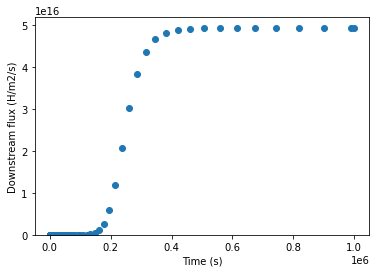

In [5]:

def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): material permeability
        L (float): material thickness
        D (float): diffusivity of H in the material

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up**0.5 * permeability / L * (2*summation + 1)
times = derived_quantities.t
computed_flux = derived_quantities.filter(surfaces=2).data

D = 1.9e-7*np.exp(-0.2/F.k_B/500)
S = 4.02e21*np.exp(-1.04/F.k_B/500)

import matplotlib.pyplot as plt
plt.scatter(times, np.abs(computed_flux)/2, label="computed")
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
import os 
script_dir = os.getcwd()
print(script_dir)
os.chdir(script_dir) 
np.savetxt('Medium_flux_festim.txt',np.column_stack([times,np.abs(computed_flux)/2]))
